In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from encoding.step_forward_converter import StepForwardConverter
from torchmetrics import MeanSquaredError

# Set random seed for reproducibility
torch.manual_seed(42)

/home/jona/mambaforge/envs/neuro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


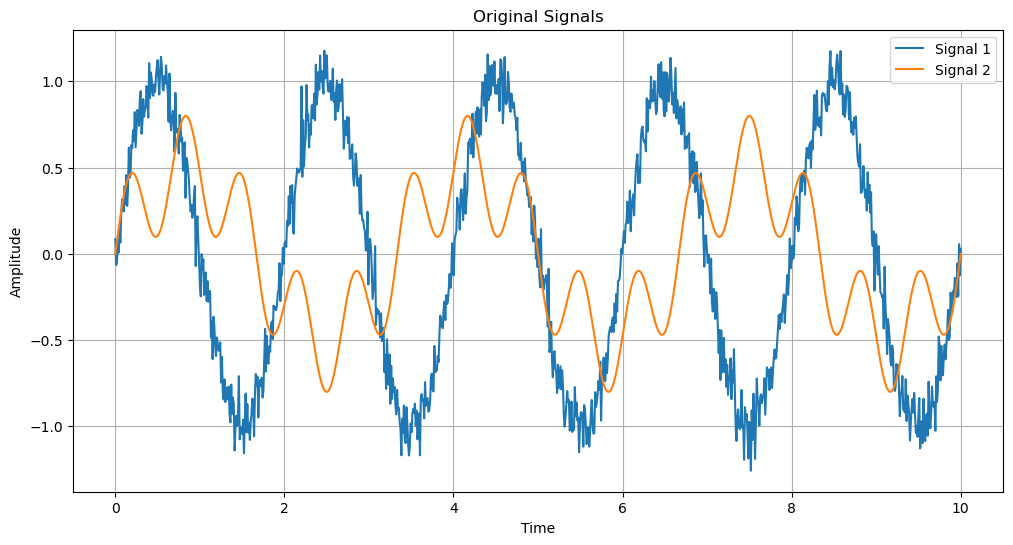

In [2]:
# Create two different signals to demonstrate multi-channel encoding
t = np.linspace(0, 10, 1000)

# Signal 1: Sine wave with noise
signal1 = np.sin(2 * np.pi * 0.5 * t) + 0.1 * np.random.randn(len(t))

# Signal 2: Combination of sine waves with different frequencies
signal2 = 0.5 * np.sin(2 * np.pi * 0.3 * t) + 0.3 * np.sin(2 * np.pi * 1.5 * t)

# Stack signals and convert to torch tensor [features, time_steps]
signals = torch.tensor(np.stack([signal1, signal2]), dtype=torch.float32)

# Plot original signals
plt.figure(figsize=(12, 6))
plt.plot(t, signal1, label='Signal 1')
plt.plot(t, signal2, label='Signal 2')
plt.title('Original Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

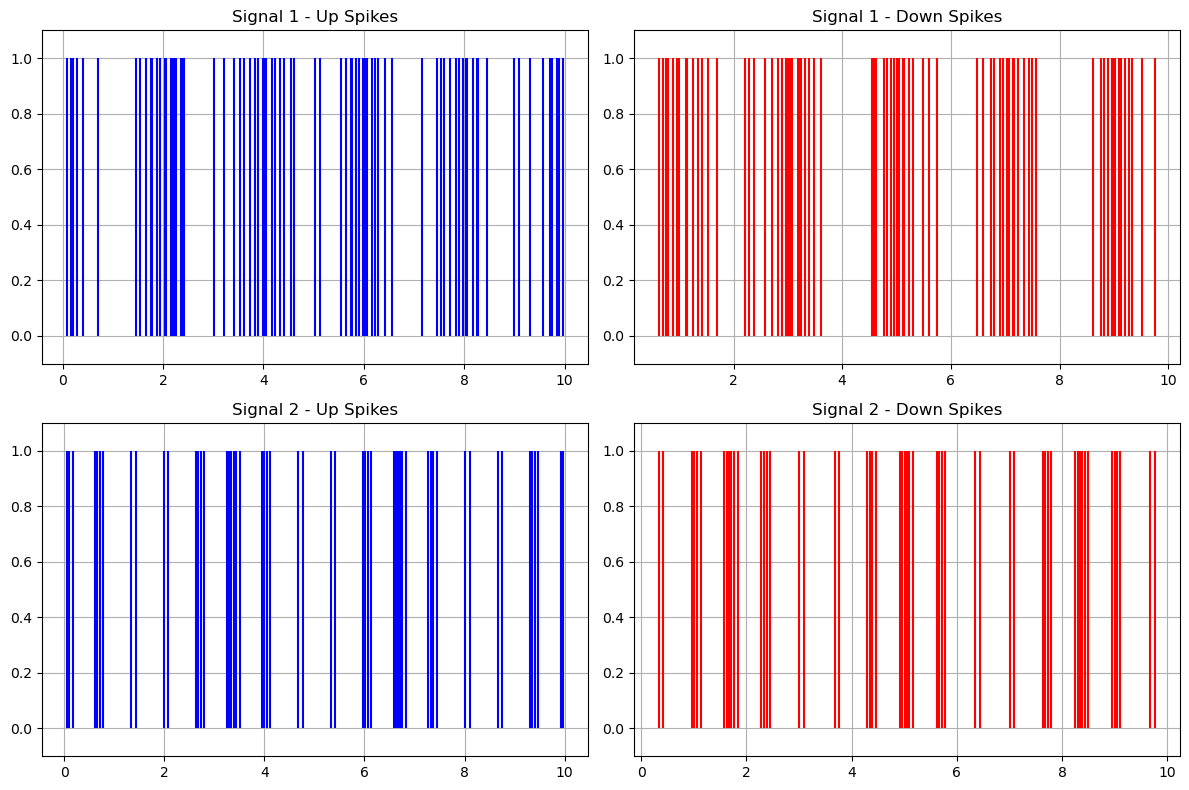

In [3]:
# Initialize the encoder with specific thresholds for each channel
encoder = StepForwardConverter(
    threshold=torch.tensor([0.2, 0.15]),  # Different thresholds for each channel
    down_spike=True                       # Enable negative spikes
)

# Encode the signals
spikes = encoder.encode(signals)

# Plot the spikes for both channels
plt.figure(figsize=(12, 8))

# Plot spikes for first signal
plt.subplot(2, 2, 1)
spike_times = t[spikes[0, 0].bool()]  # Get times where spikes occur
plt.vlines(spike_times, 0, 1, colors='b', label='Up spikes')
plt.title('Signal 1 - Up Spikes')
plt.ylim(-0.1, 1.1)
plt.grid(True)

plt.subplot(2, 2, 2)
spike_times = t[spikes[1, 0].bool()]
plt.vlines(spike_times, 0, 1, colors='r', label='Down spikes')
plt.title('Signal 1 - Down Spikes')
plt.ylim(-0.1, 1.1)
plt.grid(True)

# Plot spikes for second signal
plt.subplot(2, 2, 3)
spike_times = t[spikes[0, 1].bool()]
plt.vlines(spike_times, 0, 1, colors='b', label='Up spikes')
plt.title('Signal 2 - Up Spikes')
plt.ylim(-0.1, 1.1)
plt.grid(True)

plt.subplot(2, 2, 4)
spike_times = t[spikes[1, 1].bool()]
plt.vlines(spike_times, 0, 1, colors='r', label='Down spikes')
plt.title('Signal 2 - Down Spikes')
plt.ylim(-0.1, 1.1)
plt.grid(True)

plt.tight_layout()
plt.show()

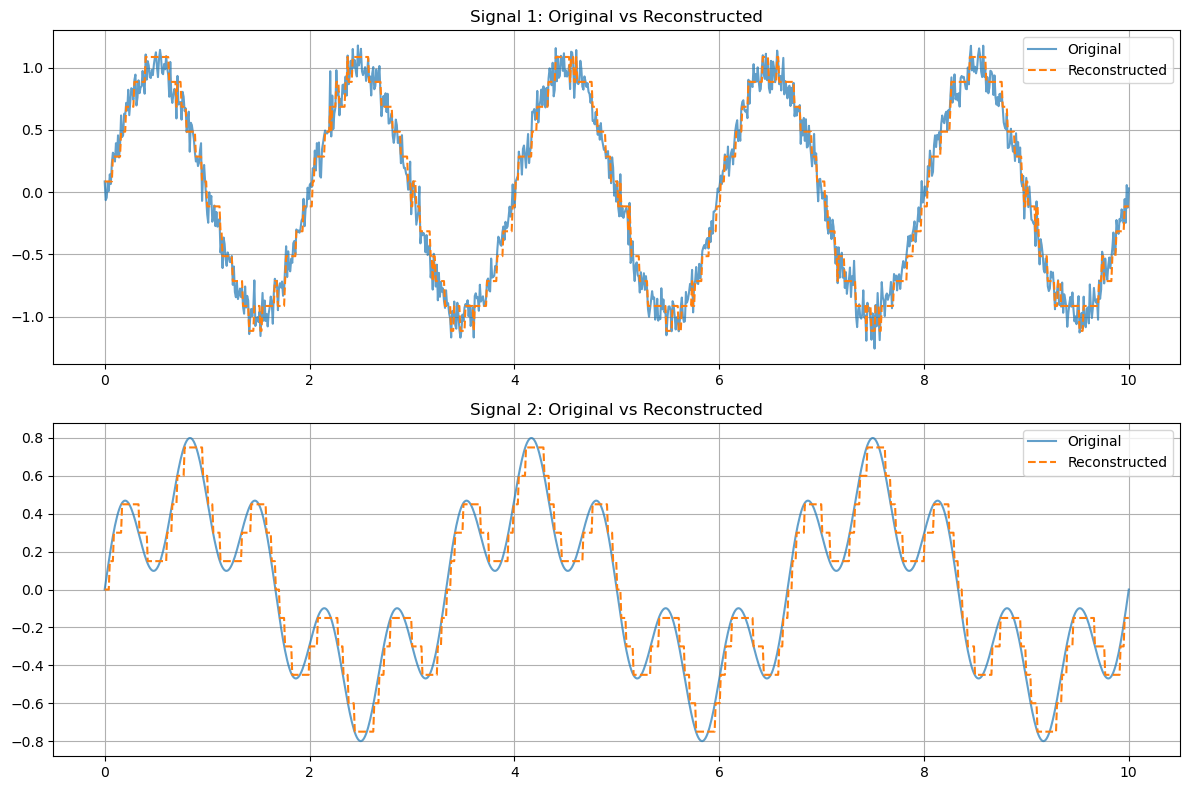

Mean Squared Error - Signal 1: 0.010153
Mean Squared Error - Signal 2: 0.005552


In [4]:
# Decode the spikes back to signals
reconstructed = encoder.decode(spikes, initial_value=signals[:, 0])

# Plot original vs reconstructed signals
plt.figure(figsize=(12, 8))

# Plot first signal comparison
plt.subplot(2, 1, 1)
plt.plot(t, signals[0], label='Original', alpha=0.7)
plt.plot(t, reconstructed[0].numpy(), label='Reconstructed', linestyle='--')
plt.title('Signal 1: Original vs Reconstructed')
plt.legend()
plt.grid(True)

# Plot second signal comparison
plt.subplot(2, 1, 2)
plt.plot(t, signals[1], label='Original', alpha=0.7)
plt.plot(t, reconstructed[1].numpy(), label='Reconstructed', linestyle='--')
plt.title('Signal 2: Original vs Reconstructed')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate and print reconstruction error for each signal
error_function = MeanSquaredError()
mse_1 = error_function(reconstructed[0], signals[0])
mse_2 = error_function(reconstructed[1], signals[1])
print(f'Mean Squared Error - Signal 1: {mse_1:.6f}')
print(f'Mean Squared Error - Signal 2: {mse_2:.6f}')

Optimizing thresholds... (this may take a few minutes)
Optimizing threshold for feature 0...


Best trial: 6. Best value: 0.00506959: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Optimizing threshold for feature 1...


Best trial: 46. Best value: 0.000385477: 100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


Original thresholds: tensor([0.1168, 0.0353])
Optimized thresholds: tensor([0.1168, 0.0353])


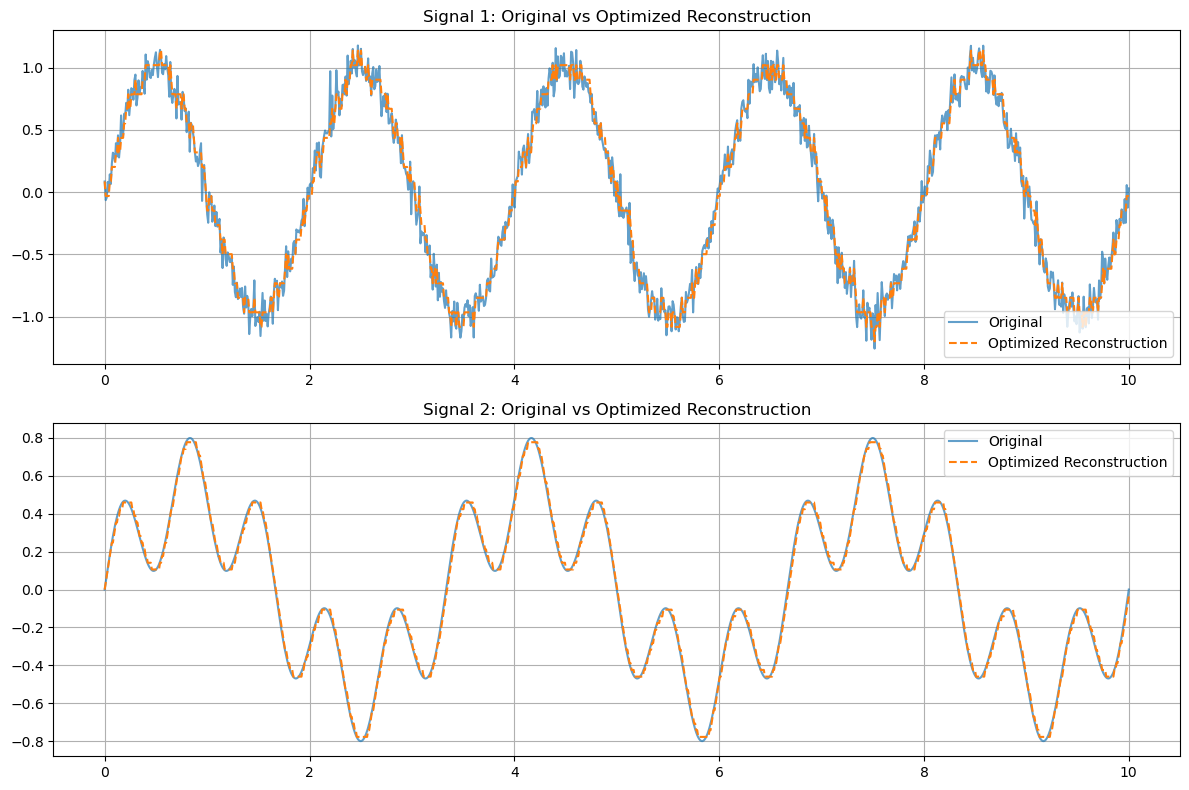

Optimized Mean Squared Error - Signal 1: 0.005070
Optimized Mean Squared Error - Signal 2: 0.000385

Spike count comparison:
Before optimization:
Signal 1 - Up spikes: 78.0, Down spikes: 79.0
Signal 2 - Up spikes: 53.0, Down spikes: 54.0

After optimization:
Signal 1 - Up spikes: 184.0, Down spikes: 185.0
Signal 2 - Up spikes: 251.0, Down spikes: 252.0


In [5]:
print("Optimizing thresholds... (this may take a few minutes)")

# Optimize thresholds for both signals
optimized_threshold = encoder.optimize(
    signals,
    error_function=MeanSquaredError(),
    plot_history=True,
)

print(f'Original thresholds: {encoder.threshold}')
print(f'Optimized thresholds: {optimized_threshold}')

# Encode and decode with optimized parameters
optimized_spikes = encoder.encode(signals)
optimized_reconstruction = encoder.decode(optimized_spikes, initial_value=signals[:, 0])

# Plot the results with optimized parameters
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, signals[0], label='Original', alpha=0.7)
plt.plot(t, optimized_reconstruction[0].numpy(), label='Optimized Reconstruction', linestyle='--')
plt.title('Signal 1: Original vs Optimized Reconstruction')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, signals[1], label='Original', alpha=0.7)
plt.plot(t, optimized_reconstruction[1].numpy(), label='Optimized Reconstruction', linestyle='--')
plt.title('Signal 2: Original vs Optimized Reconstruction')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate and print optimized reconstruction error
optimized_mse_1 = error_function(optimized_reconstruction[0], signals[0])
optimized_mse_2 = error_function(optimized_reconstruction[1], signals[1])
print(f'Optimized Mean Squared Error - Signal 1: {optimized_mse_1:.6f}')
print(f'Optimized Mean Squared Error - Signal 2: {optimized_mse_2:.6f}')

# Compare spike counts before and after optimization
print("\nSpike count comparison:")
print("Before optimization:")
print(f"Signal 1 - Up spikes: {spikes[0, 0].sum().item()}, Down spikes: {abs(spikes[1, 0].sum()).item()}")
print(f"Signal 2 - Up spikes: {spikes[0, 1].sum().item()}, Down spikes: {abs(spikes[1, 1].sum()).item()}")
print("\nAfter optimization:")
print(f"Signal 1 - Up spikes: {optimized_spikes[0, 0].sum().item()}, Down spikes: {abs(optimized_spikes[1, 0].sum()).item()}")
print(f"Signal 2 - Up spikes: {optimized_spikes[0, 1].sum().item()}, Down spikes: {abs(optimized_spikes[1, 1].sum()).item()}")